# Kernel based discrepancies

One definition of discrepancy starts with a symmetric, positive definite kernel, $K:[0,1]^d\times [0,1]^d \to \mathbb{R}$, i.e.,
\begin{gather*}
K(\boldsymbol{t},\boldsymbol{x}) = K(\boldsymbol{x},\boldsymbol{t}) \qquad \forall \boldsymbol{t}, \boldsymbol{x} \in [0,1]^d \\
\sum_{i,j = 1}^{n} c_i K(\boldsymbol{x}_i,\boldsymbol{x}_j ) \boldsymbol{c}_j > 0 \qquad \forall \boldsymbol{c} \ne \boldsymbol{0}, \ \boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \text{ distinct and } \in [0,1]^d
\end{gather*}
The discrepancy, $D(\{\boldsymbol{x}\}_{i=1}^n)$ is defined in terms of the kernel as
$$
[D(\{\boldsymbol{x}_i\}_{i=1}^n,K)]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x}
- \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(\boldsymbol{t}, \boldsymbol{x}_i) \, \mathrm{d}\boldsymbol{t}
+ \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
The discrepancy requires $\mathcal{O}(dn^2)$ operations to compute, assuming one evaluation of the kernel requires $d$ operations to compute.

We can simplify the cost to compute the discrepancy for a randomly shifted Kronecker sequence:
$$
\begin{aligned}
\text{Kronecker: } \mathbb{E}\{[D(\{i\boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} \widetilde{K}((i - j)\boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& =  - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} 
+ \frac 1{n^2} \sum_{k=1-n}^{n-1}  (n -  \lvert k \rvert)\widetilde{K}(k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t}
+ \frac 1{n^2} \biggl[n \widetilde{K}(\boldsymbol{0}) +  2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \biggr] \\
\end{aligned}
$$

$$
2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
= 2\left(n\sum_{k=1}^{n-1} \widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) - \sum_{k=1}^{n-1} k\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1})\right)
$$

After splitting the above summation, we can compute the discrepancy values for n = 1,2,...,N in $\mathcal{O}(dN)$ time.
The code can be found at qmcpy/discrete_distribution/kronecker.py.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qmcpy as qp
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

# Example with a Specified $\widetilde{K}$

Take $\widetilde{K}(x) = \prod_{\ell = 1}^d \left [1 + \gamma_\ell B_2(x_\ell) \right] = \prod_{\ell = 1}^d \left [1 + \gamma_\ell \left \{x_\ell(x_\ell - 1) + \frac 16 \right\}\right] $ with $d=2$ and $\gamma_\ell = 1$.

In [2]:
def k_tilde(x, gamma):
    return np.prod(1 + (x * (x - 1) + 1/6) * gamma)

Some examples with random alphas:

[0.5488135  0.71518937]


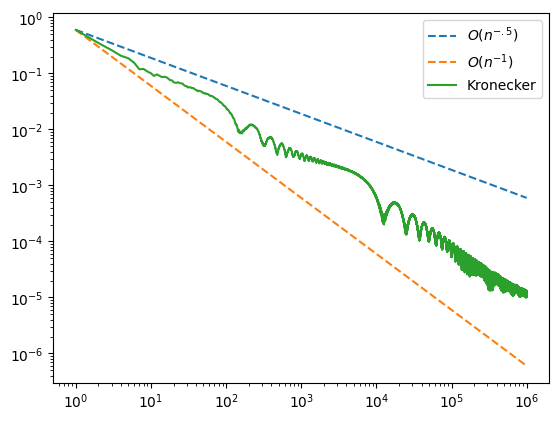

[0.417022   0.72032449]


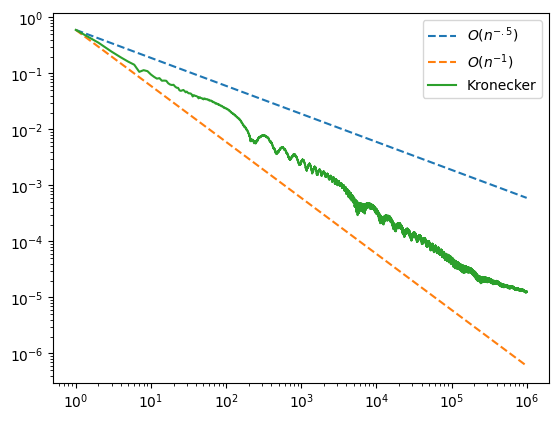

[0.4359949  0.02592623]


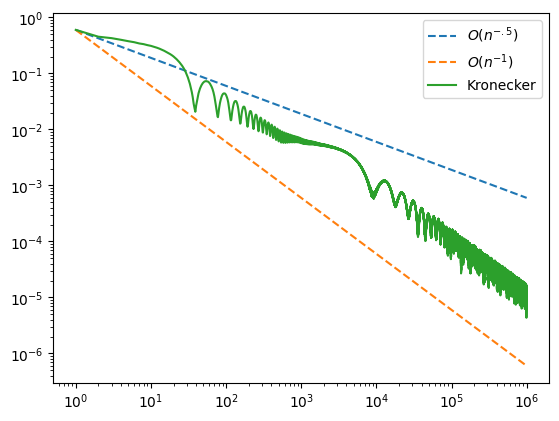

[0.5507979  0.70814782]


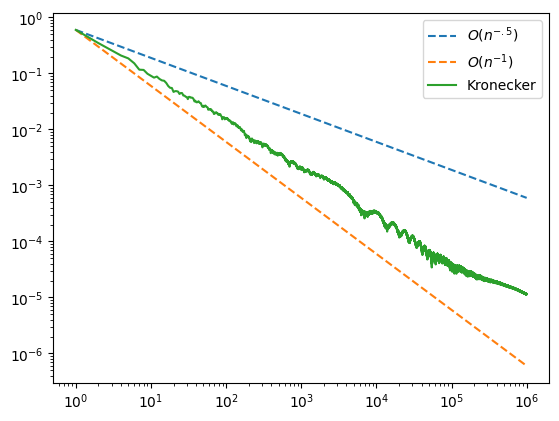

[0.96702984 0.54723225]


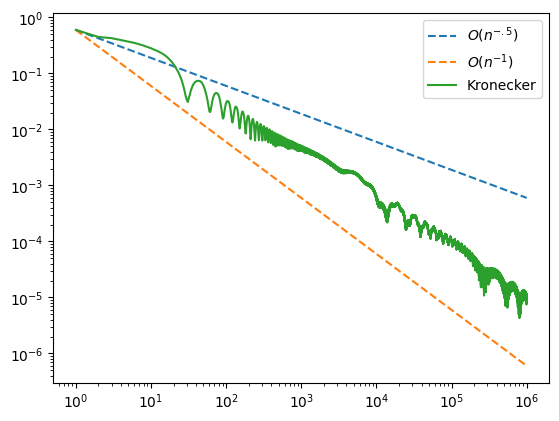

In [3]:
for i in range(5):
    np.random.seed(i)
    random = np.random.rand(2)
    print(random)
    kronecker = qp.Kronecker(dimension=2, alpha=random)
    values = kronecker.periodic_discrepancy(int(1e6), k_tilde, np.ones(2), 1)
    
    x = np.arange(1, int(1e6) + 1)
    y = values[0] / x # multiply by values[0] to get the same starting point
    y_half = values[0] / np.sqrt(x)

    plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
    plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
    plt.loglog(x, values, label="Kronecker")

    plt.legend()
    plt.show()

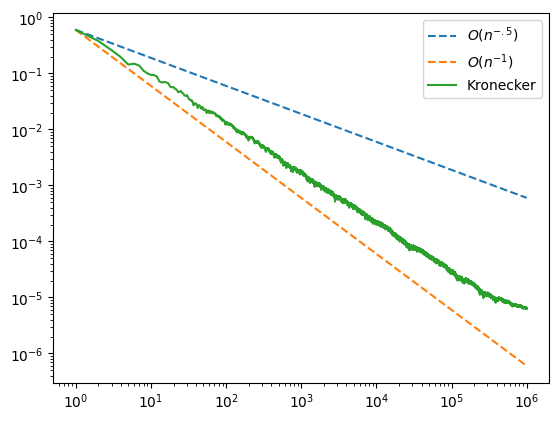

In [4]:
# alpha comes from a call to alpha_generate(2, 1000, 10000) in demos/Kronecker.ipynb
kronecker = qp.Kronecker(dimension=2, alpha=[0.38169895, 0.21603421])
values = kronecker.periodic_discrepancy(int(1e6), k_tilde, np.ones(2), 1)
x = np.arange(1, int(1e6) + 1)
y = values[0] / x
y_half = values[0] / np.sqrt(x)

plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
plt.loglog(x, values, label="Kronecker")

plt.legend()
plt.show()

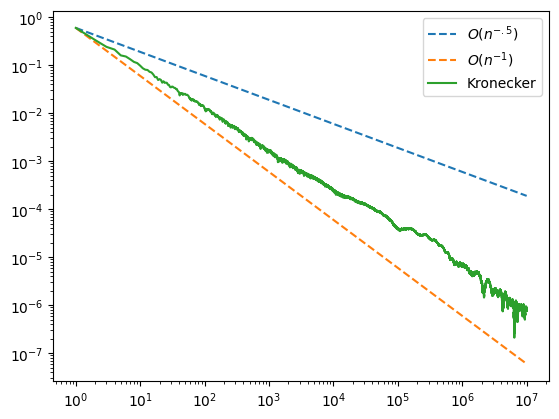

In [5]:
# would calling alpha_generate for 10 dimensions and taking the first two components be good choices for the first two dimensions?
kronecker = qp.Kronecker(dimension=2, alpha=[0.36626695, 0.41351539])
values = kronecker.periodic_discrepancy(int(1e7), k_tilde, np.ones(2), 1)
x = np.arange(1, int(1e7) + 1)
y = values[0] / x
y_half = values[0] / np.sqrt(x)

plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
plt.loglog(x, values, label="Kronecker")
plt.legend()
plt.show()

### Weighted Sum of Squares of Discrepancy

In [15]:
# from Kronecker.ipynb
def wtdsumsqdisckron(alphamat, dimension, sample, n = 50, Time = False, discwt = None,coordwts = np.arange(1,51).reshape((50, 1))):
    n_al = np.size(alphamat)
    d = dimension
    #Use numpy's shape function to find dimension d and the different number of samples for alpha in [0,.5)^d
    coordwts = coordwts[0:d]
    #Makes sure we don't have extra values for coordinate weights
    if discwt == None:
        Discwt = np.arange(1,n+1).reshape((n, 1))
        #If discwt was not specified. Go ahead with the calculation.
    else:
        Discwt = discwt(n)
    #Need to find beta, which is to take the sum of Discwt.
    beta = np.sum(Discwt)
    squared = (np.arange(1,n+1).reshape((n, 1)))**2 
    #To find bhat, for each element take Discwt / squared.
    bhat = Discwt / squared
    #Unlike Matlab, in python to reverse the order of bhat, we have to use np.flip
    #As python's cumsum is different from Matlab's cumsum, as 1 goes 1 way while
    #the other goes in the opposite direction which is why I flipped it again.
    btilde = np.cumsum(np.flip(bhat))
    btilde = np.flip(btilde)
    #Use np.squeeze to minimize the size of btilde and to do the np.flip appropraiately
    A = np.flip(np.squeeze(btilde))
    A[1:n] = A[0:n-1]
    A[0] = 0
    #For the 3 lines of code above, when playing with the matlab code, you shift each element in the array
    #by 1 towards the end. However, the first element must be 0.
    btilde = A + np.flip(np.squeeze(bhat))
    b = np.flip(np.cumsum(btilde))
    #To calculate b, you have to use cumsum and then flip it due to the fact that it's not in the right
    #order based off of the Matlab code while converting it
    kronecker= qp.Kronecker(alpha = alphamat)
    xkron = kronecker.gen_samples(n)
    #I had to redesign kronecker, so that it can deal with multiple choices of alpha.
    kernelkron = (1 + (0.5*coordwts[d-1]*(xkron*(xkron-1) + 1/6)))
    kernelkron = sample.reshape((n,1))*kernelkron
    wssd = -1*beta
    wssd = wssd + b[0]*kernelkron[0,:] + 2*np.sum(b[1:n].reshape((n-1, 1))*kernelkron[1:n, :],0)
    return wssd

In [7]:
def k_tilde(x, gamma):
    return (1 + (0.5*gamma[x.shape[0]-1]*(x * (x-1) + 1/6)))

In [8]:
alpha = np.random.rand(2)
dimension = 2
print(alpha)

[0.97268436 0.71481599]


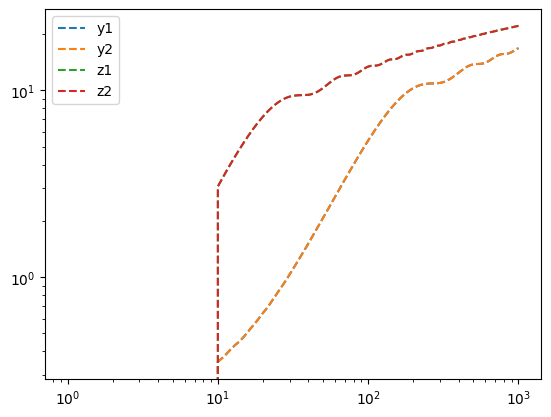

In [16]:
x = np.arange(1, 1001)
y1 = np.zeros(1000)
y2 = np.zeros(1000)

z1 = np.zeros(1000)
z2 = np.zeros(1000)

kron = qp.Kronecker(dimension=dimension, alpha=alpha)
for n in range(10, 1001):
    y1[n-1] = min(kron.wssd_discrepancy(np.ones(n), n, np.arange(1, n+1), k_tilde, np.ones(2), 1))
    z1[n-1] = max(kron.wssd_discrepancy(np.ones(n), n, np.arange(1, n+1), k_tilde, np.ones(2), 1))
    y2[n-1] = min(wtdsumsqdisckron(alpha, dimension, np.ones(n), n = n, Time = False, discwt = None, coordwts = np.ones(n)))
    z2[n-1] = max(wtdsumsqdisckron(alpha, dimension, np.ones(n), n = n, Time = False, discwt = None, coordwts = np.ones(n)))

plt.loglog(x, y1, label = 'y1', linestyle = '--')
plt.loglog(x, y2, label = 'y2', linestyle = '--')
plt.loglog(x, z1, label = 'z1', linestyle = '--')
plt.loglog(x, z2, label = 'z2', linestyle = '--')
plt.legend()
plt.show()

In [17]:
np.allclose(y1,y2)

True

In [18]:
np.allclose(z1,z2)

True